# Prédiction de consommation

In [60]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.transforms as mtrans

import feather

from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmse, meanabs

# Charge le fichier feather
df = pd.read_feather('data/energy.ftr')
df = df.set_index('date')

import warnings
warnings.filterwarnings("ignore")

sns.set_style = "seaborn-whitegrid"
sns.set_context("paper")


color = "#333"
bck_color = "#fff"
grid_color = "#ddd"

dark_mode = True
if dark_mode:
    color = "#eee"
    bck_color = "#333"
    grid_color = "#666"


charts_colors = {
    "blue_light": "#26ffff",
    "blue": "#2696ff",
    "blue_dark": "#0759a6",

    "pink_light": "#fdc2ff",
    "pink": "#f830ff",
    "pink_dark": "#830087",

    "orange_light": "#ffdc8c",
    "orange": "#ffc130",
    "orange_dark": "#de9a00",

    "yellow_light": "#fcffcc",
    "yellow": "#ffff00",
    "yellow_dark": "#8f8f09",

    "green_light": "#abffa6",
    "green": "#33ff26",
    "green_dark": "#157a0f",

    "red_light": "#ff7878",
    "red": "#ED0000",
    "red_dark": "#a11515"   
}
    

sns.set(
    rc={
        "axes.facecolor": bck_color,
        "grid.color": grid_color,
        "grid.linestyle": "-",
        "figure.facecolor": bck_color,
        "text.color": color,
        "xtick.color": color,
        "ytick.color": color,
        "axes.labelcolor": color,
        "axes.titlecolor": color,
        "axes.grid": True,
        'axes.spines.left': True,
        'axes.spines.bottom': True,
        'axes.spines.right': False,
        'axes.spines.top': False,
        "axes.edgecolor": grid_color,
    }
)

In [61]:
# To tW

df['production'] = df['thermique'] + df['nucleaire'] + df['eolien'] + df['solaire'] + df['hydraulique'] + df['bioenergies']
df['production'] = df['production'] / 1000
df['consommation'] = df['consommation'] / 1000

data = df[df.index.year > 2012][['consommation', 'production']]
data = data.groupby(pd.Grouper(freq='M')).sum()
data.index = data.index.strftime('%Y-%m')
data.index = pd.to_datetime(data.index)

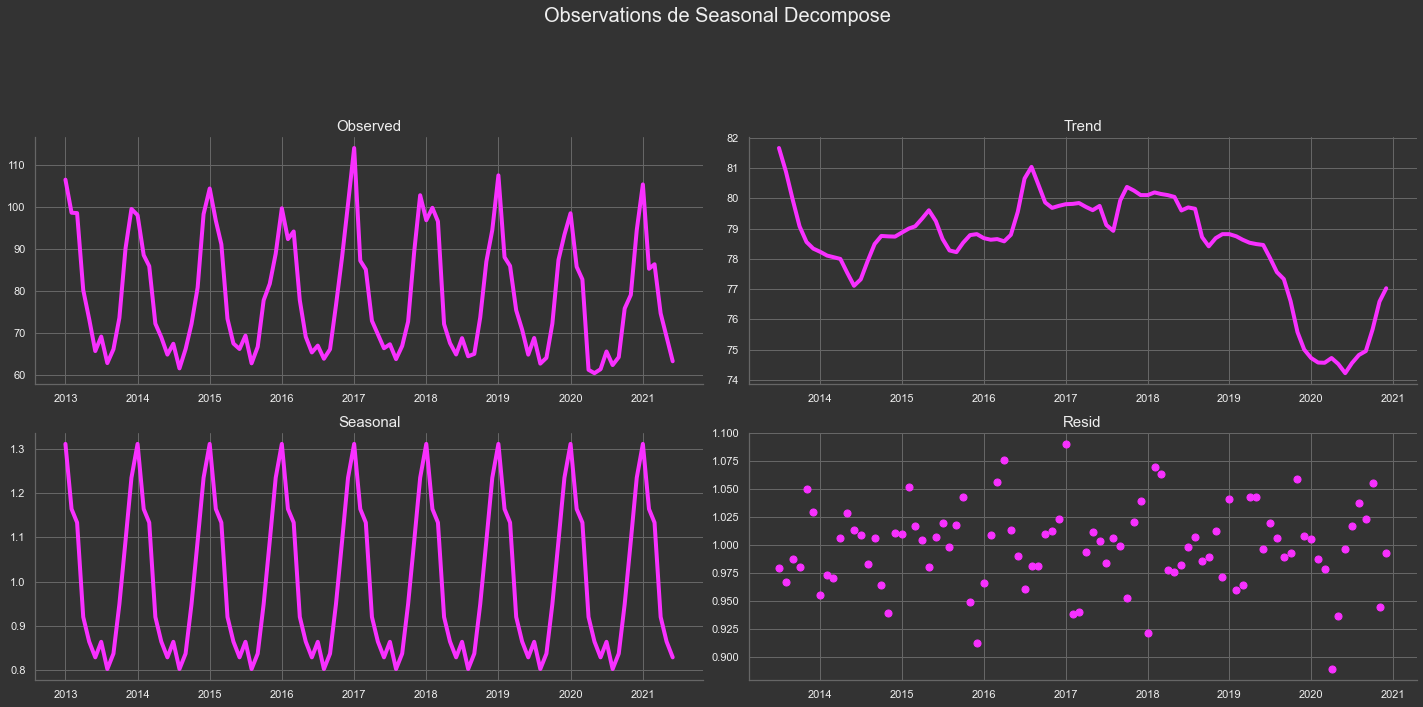

In [62]:
decompose = seasonal_decompose(data['consommation'], model='multiplicative')


fig, ax = plt.subplots(2, 2, figsize=(20, 10))
fig.tight_layout(h_pad=3)

trans = mtrans.Affine2D().translate(35, 0)

fig.suptitle('Observations de Seasonal Decompose', fontsize=20)
fig.subplots_adjust(top=.8)

ax[0, 0].plot(decompose.observed, color=charts_colors["pink"], linewidth=4)
ax[0, 0].set_title('Observed', fontsize=15)


ax[0, 1].plot(decompose.trend, color=charts_colors["pink"], linewidth=4)
ax[0, 1].set_title('Trend', fontsize=15)


ax[1, 0].plot(decompose.seasonal, color=charts_colors["pink"], linewidth=4)
ax[1, 0].set_title('Seasonal', fontsize=15)


ax[1, 1].scatter(decompose.resid.index, decompose.resid.values, marker='o', c=charts_colors["pink"], s=50)
ax[1, 1].set_title('Resid', fontsize=15)


plt.savefig("Outputs/4.1_-_Consommation_Seasonal_decompose.png", dpi=150, bbox_inches='tight')
plt.show()

In [63]:
#auto_arima(data['consommation'], m=12).summary()

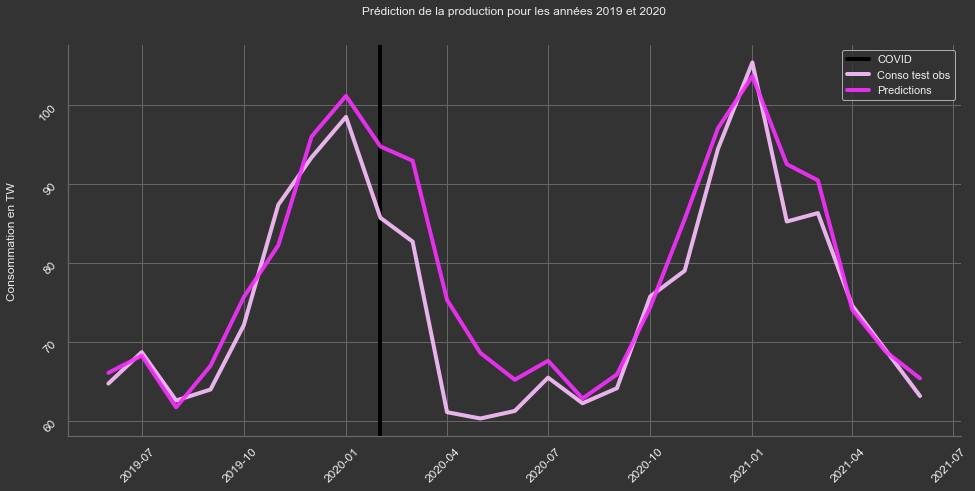

RMSE: 5.1977
MAE: 3.858 %


In [64]:
#SARIMAX(1, 0, 0)x(1, 0, [1, 2], 12)	
train = data.iloc[:77]
test = data.iloc[77:]

mod = SARIMAX(train['consommation'], order=(1, 0, 0), seasonal_order=(1, 0, [1, 2], 12))
res = mod.fit()

start = len(train)
end = len(train) + len(test) - 1

prediction = res.predict(start, end).rename('Prediction')

fig, ax = plt.subplots(figsize = (16,8))

plt.axvline(x=test.index[8], color='black', linewidth=4, label='COVID'); # Ajout de la ligne verticale

plt.plot(test.index, test['consommation'], color=charts_colors["pink_light"], linewidth=4, alpha=.9, label='Conso test obs')

ax = prediction.plot(legend=True, color=charts_colors["pink"], linewidth=4, alpha=.9, label='Predictions')

# Permet de centrer l'année sur la colonne
trans = mtrans.Affine2D().translate(15, 0)
for t in ax.get_xticklabels():
    t.set_transform(t.get_transform()+trans)

plt.xticks(fontsize=12, rotation=45)


plt.ylabel('Consommation en TW', labelpad=20)
plt.yticks(fontsize=12, rotation=45)

plt.title('Prédiction de la production pour les années 2019 et 2020', pad=30)
plt.legend(fontsize=11, loc='best')

plt.savefig("Outputs/4.2_-_SARIMAX_conso.png", dpi=150, bbox_inches='tight')

plt.show()

print('RMSE:', round(rmse(test['consommation'], prediction), 4))
print('MAE:', round(meanabs(test['consommation'], prediction), 4), '%')

preds = pd.DataFrame(prediction).reset_index()
preds.rename(columns={'index': 'date', 'Prediction': 'pred_conso'}, inplace=True)
data = data.reset_index()
data = pd.merge(left=data, right=preds, on='date', how='left')

In [65]:
#auto_arima(data['production'], m=12).summary()

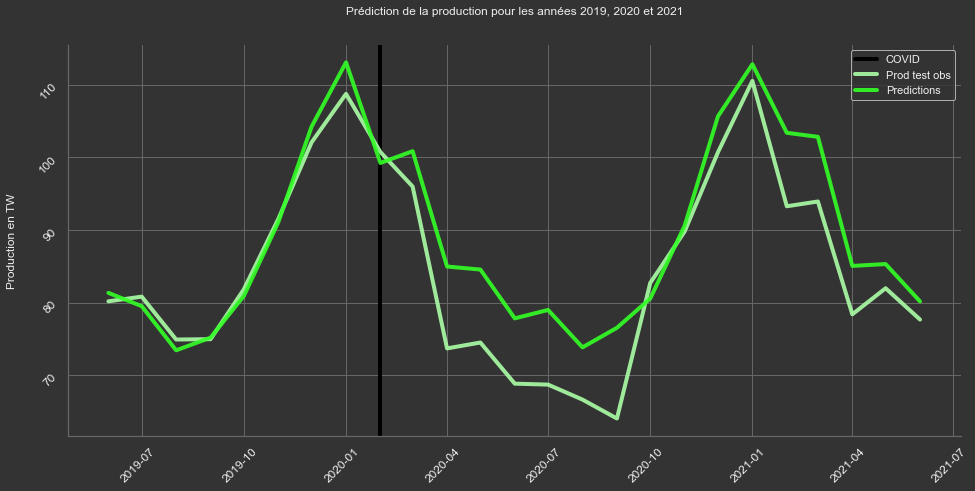

RMSE: 6.1844
MAE: 4.8149 %


In [66]:
#SARIMAX(1, 0, 0)x(2, 1, 0, 12)

mod = SARIMAX(train['production'], order=(1, 0, 0), seasonal_order=(2, 1, 0, 12))
res = mod.fit()

start = len(train)
end = len(train) + len(test) - 1

prediction = res.predict(start, end).rename('Prediction')

fig, ax = plt.subplots(figsize = (16,8))

plt.axvline(x=test.index[8], color='black', linewidth=4, label='COVID'); # Ajout de la ligne verticale

plt.plot(test.index, test['production'], color=charts_colors["green_light"], linewidth=4, alpha=.9, label='Prod test obs')

ax = prediction.plot(legend=True, color=charts_colors["green"], linewidth=4, alpha=.9, label='Predictions')

# Permet de centrer l'année sur la colonne
trans = mtrans.Affine2D().translate(15, 0)
for t in ax.get_xticklabels():
    t.set_transform(t.get_transform()+trans)

plt.xticks(fontsize=12, rotation=45)


plt.ylabel('Production en TW', labelpad=20)
plt.yticks(fontsize=12, rotation=45)

plt.title('Prédiction de la production pour les années 2019, 2020 et 2021', pad=30)
plt.legend(fontsize=11, loc='best')

plt.savefig("Outputs/4.2_-_SARIMAX_prod.png", dpi=150, bbox_inches='tight')

plt.show()

print('RMSE:', round(rmse(test['production'], prediction), 4))
print('MAE:', round(meanabs(test['production'], prediction), 4), '%')

preds = pd.DataFrame(prediction).reset_index()
preds.rename(columns={'index': 'date', 'Prediction': 'pred_prod'}, inplace=True)
data = data.reset_index()
data = pd.merge(left=data, right=preds, on='date', how='left')

In [67]:
#auto_arima(y=train['production'], X=train[['consommation']], m=12).summary()


In [68]:
# SARIMAX(0, 0, 2)x(1, 0, [1], 12)
train = data.iloc[:77]
test = data.iloc[77:]

mod = SARIMAX(train['production'], exog=train['consommation'], order=(0, 0, 2), seasonal_order=(1, 0, 1, 12))
res = mod.fit()

start = len(train)
end = len(train) + len(test) - 1

prediction = res.predict(start, end, exog=test[['pred_conso']]).rename('Prediction')

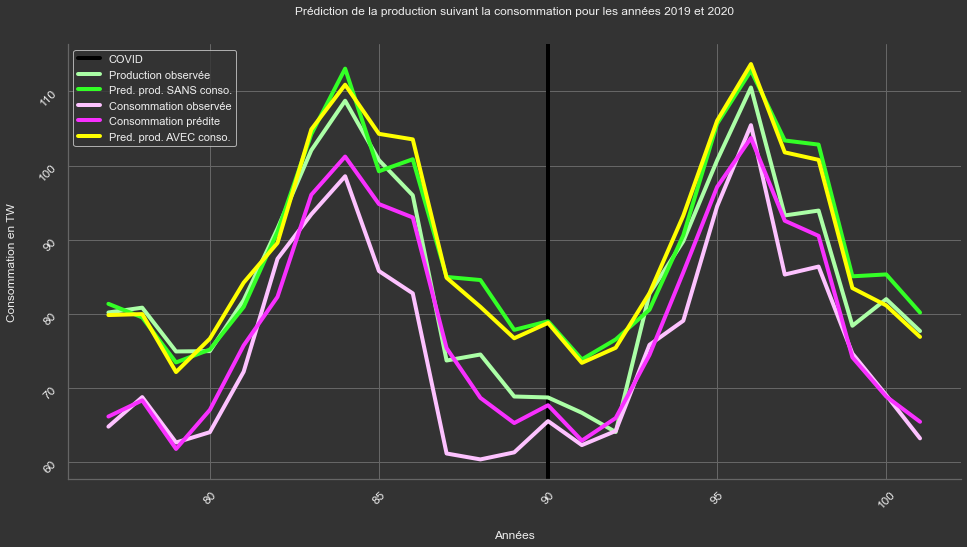

In [69]:
fig, ax = plt.subplots(figsize = (16,8))

#color=charts_colors["pink"], linewidth=4

plt.axvline(x=test.index[13], color='black', linewidth=4, label='COVID'); # Ajout de la ligne verticale


test['production'].plot(legend=True, color=charts_colors["green_light"], linewidth=4, label='Production observée')
test['pred_prod'].plot(legend=True, color=charts_colors["green"], linewidth=4, label='Pred. prod. SANS conso.')

test['consommation'].plot(legend=True, color=charts_colors["pink_light"], linewidth=4, label='Consommation observée')
test['pred_conso'].plot(legend=True, color=charts_colors["pink"],linewidth=4, label='Consommation prédite')

ax = prediction.plot(legend=True, color=charts_colors['yellow'], linewidth=4, label='Pred. prod. AVEC conso.')

plt.xlabel('Années', labelpad=20)

plt.xticks(fontsize=12, rotation=45)

plt.ylabel('Consommation en TW', labelpad=20)
plt.yticks(fontsize=12, rotation=45)

plt.title('Prédiction de la production suivant la consommation pour les années 2019 et 2020', pad=30)
plt.legend(fontsize=11, loc='best')
plt.savefig("Outputs/5.3_-_SARIMAX_prod_conso.png", dpi=150, bbox_inches='tight')
plt.show()

In [71]:
train.index

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
            68, 69, 70, 71, 72, 73, 74, 75, 76],
           dtype='int64')